In [1]:
from pyspark.sql.functions import col,min,max,year,udf,when,substring,month,sum
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Creating Spark Session variable
from pyspark.sql import SparkSession
ss = SparkSession.builder.appName('gk_nyc_parking').getOrCreate()

In [3]:
def print_bold(line):
    print('\033[1m' +line+'\033[0m')

### Importing Data

In [4]:
nyc_df = ss.read.format('csv').option('header','true').load('/common_folder/nyc_parking/Parking_Violations_Issued_-_Fiscal_Year_2017.csv')

In [5]:
nyc_df.cache()

DataFrame[Summons Number: string, Plate ID: string, Registration State: string, Issue Date: string, Violation Code: string, Vehicle Body Type: string, Vehicle Make: string, Violation Precinct: string, Issuer Precinct: string, Violation Time: string]

### shape of the dataframe

In [6]:
rows1 = nyc_df.count()
columns1 = len(nyc_df.columns)
print(type(nyc_df))
print_bold('number of Rows:')
print(rows1)
print_bold('number of Columns:')
print(columns1)

<class 'pyspark.sql.dataframe.DataFrame'>
number of Rows:
10803028
number of Columns:
10


### Printing Schema

In [7]:
nyc_df.printSchema()

root
 |-- Summons Number: string (nullable = true)
 |-- Plate ID: string (nullable = true)
 |-- Registration State: string (nullable = true)
 |-- Issue Date: string (nullable = true)
 |-- Violation Code: string (nullable = true)
 |-- Vehicle Body Type: string (nullable = true)
 |-- Vehicle Make: string (nullable = true)
 |-- Violation Precinct: string (nullable = true)
 |-- Issuer Precinct: string (nullable = true)
 |-- Violation Time: string (nullable = true)



### Data overview

In [8]:
nyc_df.limit(5).toPandas()

,Summons Number,Plate ID,Registration State,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Violation Precinct,Issuer Precinct,Violation Time
0,5092469481,GZH7067,NY,2016-07-10,7,SUBN,TOYOT,0,0,0143A
1,5092451658,GZH7067,NY,2016-07-08,7,SUBN,TOYOT,0,0,0400P
2,4006265037,FZX9232,NY,2016-08-23,5,SUBN,FORD,0,0,0233P
3,8478629828,66623ME,NY,2017-06-14,47,REFG,MITSU,14,14,1120A
4,7868300310,37033JV,NY,2016-11-21,69,DELV,INTER,13,13,0555P


# 1 Basic Data checks

## 1.1 Data type correction

`'Summons Number','Violation Code','Violation Precinct','Issuer Precinct'` are all numbers, hence converting them into int/BigInt and converting `Issue Date` into timestamp.

In [9]:
for x in ['Violation Code','Violation Precinct','Issuer Precinct']:
    nyc_df = nyc_df.withColumn(x,col(x).cast('Int'))
nyc_df = nyc_df.withColumn('Summons Number',col('Summons Number').cast(LongType()))
nyc_df = nyc_df.withColumn('Issue Date',col('Issue Date').cast('timestamp'))


In [10]:
nyc_df.printSchema()

root
 |-- Summons Number: long (nullable = true)
 |-- Plate ID: string (nullable = true)
 |-- Registration State: string (nullable = true)
 |-- Issue Date: timestamp (nullable = true)
 |-- Violation Code: integer (nullable = true)
 |-- Vehicle Body Type: string (nullable = true)
 |-- Vehicle Make: string (nullable = true)
 |-- Violation Precinct: integer (nullable = true)
 |-- Issuer Precinct: integer (nullable = true)
 |-- Violation Time: string (nullable = true)



In [11]:
nyc_df.limit(5).toPandas()

,Summons Number,Plate ID,Registration State,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Violation Precinct,Issuer Precinct,Violation Time
0,5092469481,GZH7067,NY,2016-07-10,7,SUBN,TOYOT,0,0,0143A
1,5092451658,GZH7067,NY,2016-07-08,7,SUBN,TOYOT,0,0,0400P
2,4006265037,FZX9232,NY,2016-08-23,5,SUBN,FORD,0,0,0233P
3,8478629828,66623ME,NY,2017-06-14,47,REFG,MITSU,14,14,1120A
4,7868300310,37033JV,NY,2016-11-21,69,DELV,INTER,13,13,0555P


Replacing `space` with `underscore` in column names

In [12]:
columns_list = nyc_df.schema.names

In [13]:
for column in columns_list:
    new_column = column.replace(' ','_')
    nyc_df = nyc_df.withColumnRenamed(column,new_column)

In [14]:
columns_list = nyc_df.schema.names
print(columns_list)

['Summons_Number', 'Plate_ID', 'Registration_State', 'Issue_Date', 'Violation_Code', 'Vehicle_Body_Type', 'Vehicle_Make', 'Violation_Precinct', 'Issuer_Precinct', 'Violation_Time']


## 1.2 Check on the Issue year

In [15]:
nyc_df.select(year('Issue_date')).take(5)

[Row(year(Issue_date)=2016),
 Row(year(Issue_date)=2016),
 Row(year(Issue_date)=2016),
 Row(year(Issue_date)=2017),
 Row(year(Issue_date)=2016)]

In [16]:
print_bold('distinct years:')
print(nyc_df.select(year('Issue_date')).distinct().count())

distinct years:
55


In [17]:
nyc_df.groupby(year('Issue_date')).count().sort(year('Issue_date')).show(55)

+----------------+-------+
|year(Issue_date)|  count|
+----------------+-------+
|            1972|      2|
|            1973|      2|
|            1974|      1|
|            1976|      1|
|            1977|      1|
|            1984|      1|
|            1985|      1|
|            1990|      2|
|            1991|      3|
|            1994|      1|
|            1996|      1|
|            1997|      1|
|            2000|    185|
|            2001|      2|
|            2002|      1|
|            2003|      1|
|            2004|      2|
|            2005|      1|
|            2006|      8|
|            2007|     18|
|            2008|      4|
|            2009|      3|
|            2010|     48|
|            2011|     22|
|            2012|     87|
|            2013|     70|
|            2014|    120|
|            2015|    419|
|            2016|5368391|
|            2017|5431918|
|            2018|   1057|
|            2019|    472|
|            2020|     22|
|            2021|     22|
|

There are 55 years for which parking issues have been issued with minimum year being 1972 and max year being 2069. There seems to some inconsistencies in data, as there cannot be any tickets which year greater then 2069. Since we are considering only the year 2017 for this analysis we are not worried about these issues.

In [18]:
nyc_2017 = nyc_df.filter(year(nyc_df['Issue_date']) == 2017)

In [19]:
nyc_df.cache()

DataFrame[Summons_Number: bigint, Plate_ID: string, Registration_State: string, Issue_Date: timestamp, Violation_Code: int, Vehicle_Body_Type: string, Vehicle_Make: string, Violation_Precinct: int, Issuer_Precinct: int, Violation_Time: string]

In [20]:
nyc_2017.groupby(year('Issue_date')).count().show()

+----------------+-------+
|year(Issue_date)|  count|
+----------------+-------+
|            2017|5431918|
+----------------+-------+



There are 54,31,918 tickets that have been issues in 2017.

In [21]:
columns_list = nyc_2017.schema.names
rows2 = nyc_2017.count()

## 1.3 Duplicate check

Check to see if any of the `summons_numbers` are repeated, if there are any then they are duplicates

In [22]:
if rows2 != nyc_2017.dropDuplicates(['Summons_Number']).count():
    print_bold('Duplicates are present')
else :
    print_bold('No duplicates')

No duplicates


To see if same vehicle at the same time as been charged with two different summons and no such records are present

In [23]:
temp_list = columns_list.copy()
if rows2 != nyc_2017.dropDuplicates(temp_list.remove('Summons_Number')).count():
    print_bold('Duplicates are present')
else :
    print_bold('No duplicates')

No duplicates


## 1.4 Null value checks

In [24]:
print_bold('null value count column wise:')
for column in columns_list:
    null_str = column+' is null'
    null_count = nyc_2017.filter(null_str).count()
    print('{0:<20} {1:>10}'.format(column, null_count))

null value count column wise:
Summons_Number                0
Plate_ID                      0
Registration_State            0
Issue_Date                    0
Violation_Code                0
Vehicle_Body_Type             0
Vehicle_Make                  0
Violation_Precinct            0
Issuer_Precinct               0
Violation_Time                0


### 1.4.1 Summons_Number

In [25]:
nyc_2017.select(min(col('Summons_Number')),max(col('Summons_Number'))).show()

+-------------------+-------------------+
|min(Summons_Number)|max(Summons_Number)|
+-------------------+-------------------+
|         1002884949|         8585600044|
+-------------------+-------------------+



In [26]:
nyc_2017.createOrReplaceTempView("nyc2017")

### 1.4.2 Registration_State

In [27]:
#check to see if any special characters are present
ss.sql("select count(1) from nyc2017 where Registration_State regexp '[^a-zA-Z0-9]'").show()

+--------+
|count(1)|
+--------+
|       0|
+--------+



It is given that 99 registration_State has to be replaced with the state that has highest number of entries.`NY` has the highest number of entries therefore replacing `99` with `NY` 

In [28]:
nyc_2017.groupby('Registration_State').count().sort(col('count').desc()).show(5)

+------------------+-------+
|Registration_State|  count|
+------------------+-------+
|                NY|4273951|
|                NJ| 475825|
|                PA| 140286|
|                CT|  70403|
|                FL|  69468|
+------------------+-------+
only showing top 5 rows



In [29]:
nyc_2017 = nyc_2017.withColumn('Registration_State',when(nyc_2017['Registration_State'] == '99','NY').otherwise(nyc_2017['Registration_State']))

In [30]:
nyc_2017.groupby('Registration_State').count().sort(col('count').desc()).show(5)
nyc_2017.filter(nyc_2017['Registration_State']=='99').show()

+------------------+-------+
|Registration_State|  count|
+------------------+-------+
|                NY|4290006|
|                NJ| 475825|
|                PA| 140286|
|                CT|  70403|
|                FL|  69468|
+------------------+-------+
only showing top 5 rows

+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|Summons_Number|Plate_ID|Registration_State|Issue_Date|Violation_Code|Vehicle_Body_Type|Vehicle_Make|Violation_Precinct|Issuer_Precinct|Violation_Time|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+



In [31]:
nyc_2017.createOrReplaceTempView("nyc2017")

In [32]:
nyc_2017.filter(nyc_2017['Registration_State'] == 'nan').toPandas().head()

,Summons_Number,Plate_ID,Registration_State,Issue_Date,Violation_Code,Vehicle_Body_Type,Vehicle_Make,Violation_Precinct,Issuer_Precinct,Violation_Time


### 1.4.3. Violation_Code

There are 100 violation codes in total

In [33]:
nyc_2017.select(('Violation_Code')).distinct().count()

100

In [34]:
#check to see if any special characters are present
ss.sql("select count(1) from nyc2017 where Violation_Code regexp '[^a-zA-Z0-9]'").show()

+--------+
|count(1)|
+--------+
|       0|
+--------+



In [35]:
nyc_2017.filter(nyc_2017['Violation_Code'] == 'nan').toPandas().head()

,Summons_Number,Plate_ID,Registration_State,Issue_Date,Violation_Code,Vehicle_Body_Type,Vehicle_Make,Violation_Precinct,Issuer_Precinct,Violation_Time


### 1.4.4 Vehicle_Body_Type

In [36]:
nyc_2017.select(('Vehicle_Body_Type')).distinct().count()

1165

In [37]:
#check to see if any special characters are present
ss.sql("select count(1) from nyc2017 where Vehicle_Body_Type regexp '[^a-zA-Z0-9]'").show()

+--------+
|count(1)|
+--------+
|   43475|
+--------+



In [38]:
#check to see if any special characters are present
ss.sql("select distinct(Vehicle_Body_Type) from nyc2017 where Vehicle_Body_Type regexp '[^a-zA-Z0-9]'").show(50)

+-----------------+
|Vehicle_Body_Type|
+-----------------+
|             R/RD|
|             4D H|
|             2 DO|
|             4 DO|
|              4 D|
|             4D S|
|             TR/C|
|             VAN.|
|             W/SR|
|             W/DR|
|             P/SH|
|             SN/P|
|             2 DR|
|             S/SP|
|             TRK.|
|             RD/S|
|             H/TR|
|              C&C|
|             H/IN|
|             H/WH|
|             ST W|
|             2D H|
|             5 DO|
|              P-U|
|             4 DR|
|             5D H|
|             TR/E|
|             TRU-|
|             VEH-|
|             T/CR|
+-----------------+



There a re 1165 vehicle_body_types and out of all the rows 43,475 rows have special characters. Since we dont have any additional information of vehicle type, we are considering these as valid entries

In [39]:
print(nyc_2017.filter(nyc_2017['Vehicle_Body_Type'] == 'nan').count())

nyc_2017.filter(nyc_2017['Vehicle_Body_Type'] == 'nan').toPandas().head()


20201


,Summons_Number,Plate_ID,Registration_State,Issue_Date,Violation_Code,Vehicle_Body_Type,Vehicle_Make,Violation_Precinct,Issuer_Precinct,Violation_Time
0,1423945281,2240653,IN,2017-05-13,14,nan,FRUEH,14,420,1159A
1,1408924729,85989MD,NY,2017-01-16,14,nan,CADIL,33,33,1016A
2,1421548033,AF37508,PA,2017-06-01,46,nan,FRUEH,6,6,0555A
3,8511500900,L15036,CT,2017-02-15,46,nan,ISUZU,33,33,0841A
4,4006961923,CX716,RI,2017-02-07,5,nan,FORD,0,0,1021A


### 1.4.5 Vehicle_Make

In [40]:
nyc_2017.select(('Vehicle_Make')).distinct().count()

3179

In [41]:
#check to see if any special characters are present
ss.sql("select count(1) from nyc2017 where Vehicle_Make regexp '[^a-zA-Z0-9]'").show()

+--------+
|count(1)|
+--------+
|  251808|
+--------+



In [42]:
#check to see if any special characters are present
ss.sql("select distinct(Vehicle_Make) from nyc2017 where Vehicle_Make regexp '[^a-zA-Z0-9]'").show(50)

+------------+
|Vehicle_Make|
+------------+
|       LA//R|
|       N. CA|
|        WE/C|
|        L/RO|
|       TOW M|
|       R ROV|
|       FL/LR|
|         N/V|
|       FR/LA|
|       GRT D|
|        RA/T|
|       W/OC/|
|       WAN C|
|       G DAR|
|       BL/BD|
|       LAND/|
|       UD TR|
|       MG/BG|
|       KW TR|
|       FR. L|
|       GEO/P|
|       TR/KI|
|       MI/SU|
|       TR/TE|
|       MI /B|
|       M CAD|
|       BL BI|
|       GR/DR|
|       LO/RI|
|       FR -L|
|       JO/DE|
|       WK/LI|
|       FR/LT|
|        BL/B|
|       UT MA|
|       V OLV|
|        C/MC|
|       HA/RO|
|       BG/BI|
|       WH/GN|
|       CA/ST|
|       UT/HA|
|       INT H|
|       MR/BR|
|       WO/ST|
|        MI/F|
|       FR/LL|
|       SH LA|
|       FI/LI|
|       GRE/D|
+------------+
only showing top 50 rows



There a re 3179 vehicle_body_types and out of all the rows 2,51,808 rows have special characters. Since we dont have any additional information of vehicle type, we are considering these as valid entries

In [43]:
print(nyc_2017.filter(nyc_2017['Vehicle_Make'] == 'nan').count())

nyc_2017.filter(nyc_2017['Vehicle_Make'] == 'nan').toPandas().head()


38509


,Summons_Number,Plate_ID,Registration_State,Issue_Date,Violation_Code,Vehicle_Body_Type,Vehicle_Make,Violation_Precinct,Issuer_Precinct,Violation_Time
0,1418425369,JYW5248,PA,2017-03-21,21,SDN,nan,48,48,0952A
1,8546468965,37489BB,NY,2017-06-12,46,BUS,nan,68,68,0216P
2,8583406443,10217AV,NY,2017-06-27,38,UTIL,nan,5,5,0513P
3,1414702395,2270500,ME,2017-02-08,66,TRAI,nan,75,0,0923A
4,1415644408,49735JG,NY,2017-01-26,14,DELV,nan,1,1,0434P


### 1.4.6 Violation_Precinct

There are 171 precincts where violations happened

In [44]:
nyc_2017.select(('Violation_Precinct')).distinct().count()

171

In [45]:
nyc_2017.select(min(col('Violation_Precinct')),max(col('Violation_Precinct'))).show()

+-----------------------+-----------------------+
|min(Violation_Precinct)|max(Violation_Precinct)|
+-----------------------+-----------------------+
|                      0|                    918|
+-----------------------+-----------------------+



In [46]:
print(nyc_2017.filter(nyc_2017['Violation_Precinct'] == 'nan').count())

nyc_2017.filter(nyc_2017['Violation_Precinct'] == 'nan').toPandas().head()


0


,Summons_Number,Plate_ID,Registration_State,Issue_Date,Violation_Code,Vehicle_Body_Type,Vehicle_Make,Violation_Precinct,Issuer_Precinct,Violation_Time


### 1.4.7 Issuer_Precinct

There are 511 precincts which have issued summons

In [47]:
nyc_2017.select(('Issuer_Precinct')).distinct().count()

511

In [48]:
nyc_2017.select(min(col('Issuer_Precinct')),max(col('Issuer_Precinct'))).show()

+--------------------+--------------------+
|min(Issuer_Precinct)|max(Issuer_Precinct)|
+--------------------+--------------------+
|                   0|                 992|
+--------------------+--------------------+



In [49]:
print(nyc_2017.filter(nyc_2017['Issuer_Precinct'] == 'nan').count())

nyc_2017.filter(nyc_2017['Issuer_Precinct'] == 'nan').toPandas().head()


0


,Summons_Number,Plate_ID,Registration_State,Issue_Date,Violation_Code,Vehicle_Body_Type,Vehicle_Make,Violation_Precinct,Issuer_Precinct,Violation_Time


### 1.4.8 Violation_Time

In [50]:
nyc_2017.select(('Violation_Time')).distinct().count()

1626

In [51]:
#check to see if any special characters are present
ss.sql("select count(1) from nyc2017 where Violation_Time regexp '[^a-zA-Z0-9]'").show()

+--------+
|count(1)|
+--------+
|      29|
+--------+



In [52]:
#check to see if any special characters are present
ss.sql("select distinct(Violation_Time) from nyc2017 where Violation_Time regexp '[^a-zA-Z0-9]'").show(50)

+--------------+
|Violation_Time|
+--------------+
|         081*A|
|         09+2A|
|         09+1A|
|         10.0P|
|         094/P|
|         10+1A|
|         09.5A|
|         07.8A|
|         121/P|
|         110+A|
|         083.A|
|         074/A|
|         093+A|
|         08+7A|
|         065+A|
|         0.47A|
|         015.A|
|         06.5A|
|         073/A|
|         .933A|
|         10.3P|
|         125+A|
|         115+A|
|         103/P|
|         100.P|
|         075/P|
|         06+0P|
+--------------+



There a re 1626 Violation_Time and out of all the rows 29 rows have special characters. Since we dont have any additional information of Violation_Time, we are considering these as valid entries

In [53]:
print(nyc_2017.filter(nyc_2017['Violation_Time'] == 'nan').count())

nyc_2017.filter(nyc_2017['Violation_Time'] == 'nan').toPandas().head()


16


,Summons_Number,Plate_ID,Registration_State,Issue_Date,Violation_Code,Vehicle_Body_Type,Vehicle_Make,Violation_Precinct,Issuer_Precinct,Violation_Time
0,1404224350,FCJ5087,NY,2017-05-04,40,SUBN,NISSA,70,156,nan
1,6020463461,N27GLY,NJ,2017-01-17,94,SUBN,SUBAR,0,0,nan
2,6020332056,HGR6172,NY,2017-03-31,94,SDN,MAZDA,0,0,nan
3,6020161894,CFZ9386,NY,2017-04-26,94,SUBN,ME/BE,0,0,nan
4,6020332068,KJW6898,PA,2017-05-17,94,SDN,MITSU,0,0,nan


### 1.4.9 Plate_ID

In [54]:
nyc_2017.select(('Plate_ID')).distinct().count()

1974356

In [55]:
#check to see if any special characters are present
ss.sql("select count(1) from nyc2017 where Plate_ID regexp '[^a-zA-Z0-9]'").show()

+--------+
|count(1)|
+--------+
|     729|
+--------+



In [56]:
#check to see if any special characters are present
ss.sql("select distinct(Plate_ID) from nyc2017 where Plate_ID REGEXP '[^a-zA-Z0-9]'").show(50)

+---------+
| Plate_ID|
+---------+
|  904.VQK|
|   XALL!4|
| 4.3E+382|
|  JSS012@|
| 3(2288MJ|
|   45419(|
| 92980JE[|
|   XFCR1)|
|  Q4@2384|
|  F[E5111|
| 6.1E+255|
|  ZZ251!9|
| 1E+65329|
| HDF5748.|
|  20@8317|
| 2E+83932|
| AC.03956|
|   2E+534|
|  ZHL96^2|
|  8E+9026|
| PA.L5201|
|  FPT!383|
| WATER#$$|
|1.1562E+5|
|   GRNH#9|
| HHM2884`|
|   M,H12]|
|  XCUD5%1|
|   55518(|
|7.38E+205|
|   PF*32L|
| 3.70E+11|
| 7N96586;|
|  2897.CP|
|   E!7EZM|
|   ZCF!0X|
| 2.3E+593|
|  HNV&716|
|   JSG)51|
|  11392,A|
|   XEHL!4|
|  P[Y8049|
|  DFA1(67|
|    D735!|
| HJJ3395.|
|   G1&FZK|
|  PWD969^|
| 4.1E+733|
|  CDF455!|
|  GEX69%3|
+---------+
only showing top 50 rows



There are 19,74,356 Plate_ID and out of all the rows 729 rows have special characters. Since we dont have any additional information of Plate_ID, we are considering these as valid entries

In [57]:
nyc_2017.filter(nyc_2017.Plate_ID == 'BLANKPLATE').count()

5261

In [58]:
print(nyc_2017.filter(nyc_2017['Plate_ID'] == 'nan').count())

nyc_2017.filter(nyc_2017['Plate_ID'] == 'nan').toPandas().head()


252


,Summons_Number,Plate_ID,Registration_State,Issue_Date,Violation_Code,Vehicle_Body_Type,Vehicle_Make,Violation_Precinct,Issuer_Precinct,Violation_Time
0,8240027763,nan,NY,2017-01-14,71,4DSD,BMW,103,103,0713A
1,8581550060,nan,NY,2017-06-08,74,4DSD,OLDSM,42,42,0837A
2,8563901783,nan,NY,2017-06-09,74,SUBN,NISSA,103,103,0439P
3,7611253542,nan,NY,2017-02-24,74,SUBN,HONDA,48,48,1040A
4,7849781004,nan,NY,2017-02-16,74,SUBN,HONDA,102,102,0728A


252 rows where Plate_ID is nan.

In [59]:
nyc_2017.groupby('Plate_ID').count().sort(col('Plate_ID')).show(5)

+--------+-----+
|Plate_ID|count|
+--------+-----+
|  $46GRP|    1|
|''ZP1010|    1|
|       ,|    1|
|       .|    1|
|.88653MG|    1|
+--------+-----+
only showing top 5 rows



Plate numbers cannot be . or , or any special character. Hence these plateIDs are not valid

### Assumptions:
- The ticketing data spanned over 55 years starting from 1972 to 2069. Since the current analysis is focused only on 2017, the subset of the data corresponsing to 2017 has been considered.
- There are `'nan'` values present in mutiple *string* type columns, and these values are not detected by the inherit null methods. The reason may be that these values are stored as 'nan' string rather than the special null character.
- These values are left as is along as they are not involved in any of the required analysis
- There are also special charcters present in multiple *string* columns and since there is not explicit mention of the structure of these variables, we are considering all these values are eligible values
- There are around 5200 rows where PlateID is marked as `BLANKPLATE`, since we are not dropping any of the PlateIDs which are `'nan'`, these are also considered under same category and left as is.

## Examine Data

### Question 1 : Total number of tickets in 2017

In [60]:
print_bold('Total number of tickets in 2017:')
print(nyc_2017.count())

Total number of tickets in 2017:
5431918


__There are 5.43 million tickets were issues in 2017__ 

### Question 2: Unique States where parking tickets were issued

In [61]:
print_bold('No of rows with registration state as 99 :')
print(nyc_df.filter(year(nyc_df['Issue_date']) == 2017).filter(nyc_df['Registration_State'] == 99).count())

No of rows with registration state as 99 :
16055


__These have been replaced with the state with highest parking tickets . i.e 'NY'__ *(In data cleaning step)* 

In [62]:
print_bold('Number of records with registration state as NY before correction:')
print(nyc_df.filter(year(nyc_df['Issue_date']) == 2017).filter(nyc_df['Registration_State'] == 'NY').count())
print_bold('Number of records with registration state as NY After correction:')
print(nyc_2017.filter(nyc_2017['Registration_State'] == 'NY').count())
print_bold('difference:')
print(-nyc_df.filter(year(nyc_df['Issue_date']) == 2017).filter(nyc_df['Registration_State'] == 'NY').count() \
     + nyc_2017.filter(nyc_2017['Registration_State'] == 'NY').count())

Number of records with registration state as NY before correction:
4273951
Number of records with registration state as NY After correction:
4290006
difference:
16055


In [63]:
print_bold('Number of unqiue states:')
print(nyc_2017.select('Registration_State').distinct().count())

Number of unqiue states:
64


__There are a total of 64 states__

## Aggregation Tasks

### Question 1 :  Top 5 violation codes

In [64]:
top5_violation = nyc_2017.groupby('Violation_Code').count().sort(col('count').desc())

In [65]:
print_bold('Top 5 violation codes:')
top5_violation.show(5)

Top 5 violation codes:
+--------------+------+
|Violation_Code| count|
+--------------+------+
|            21|768087|
|            36|662765|
|            38|542079|
|            14|476664|
|            20|319646|
+--------------+------+
only showing top 5 rows



In [66]:
df = top5_violation.limit(5).toPandas()
df1 = df.copy()
df1['count'] = round(100*df1['count']/rows2,2)
code_order = df.sort_values('count',ascending = False).Violation_Code

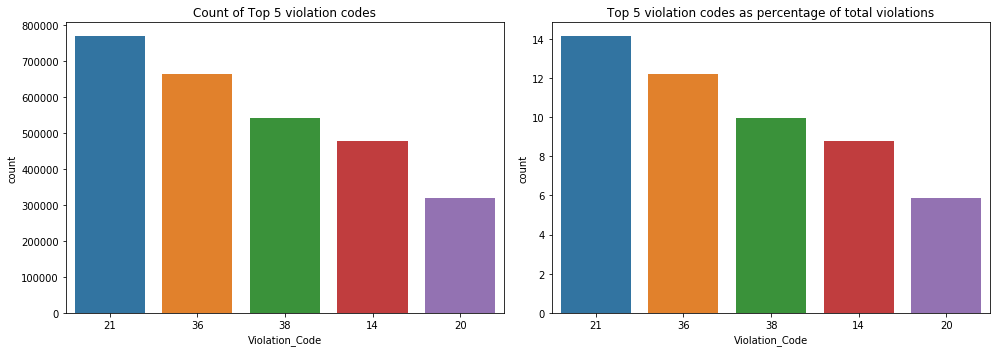

In [67]:
plt.figure(figsize = (14,5))
plt.subplot(1,2,1)
sns.barplot(x = 'Violation_Code',y = 'count',data = df,order = code_order)
plt.gca().set_title('Count of Top 5 violation codes')
plt.subplot(1,2,2)
sns.barplot(x = 'Violation_Code',y = 'count',data = df1,order = code_order)
plt.gca().set_title('Top 5 violation codes as percentage of total violations')
plt.tight_layout()
plt.show()

In [68]:
# Sum of percentages
df1['count'].sum()

50.980000000000004

The top 5 violation codes are `21,36,38,14 and 20` and all of then combined compraise a total of about `51%` of total violations

### Question 2 : Top 5 vehicle_body_types and vehicle_makes

In [69]:
top5_vbt = nyc_2017.groupby('Vehicle_Body_Type').count().sort(col('count').desc())
top5_vm = nyc_2017.groupby('Vehicle_Make').count().sort(col('count').desc())

In [70]:
print_bold('Top 5 Vehicle body type with violations:')
top5_vbt.show(5)
print_bold('Top 5 Vehicle Makes with violations:')
top5_vm.show(5)

Top 5 Vehicle body type with violations:
+-----------------+-------+
|Vehicle_Body_Type|  count|
+-----------------+-------+
|             SUBN|1883954|
|             4DSD|1547312|
|              VAN| 724029|
|             DELV| 358984|
|              SDN| 194197|
+-----------------+-------+
only showing top 5 rows

Top 5 Vehicle Makes with violations:
+------------+------+
|Vehicle_Make| count|
+------------+------+
|        FORD|636844|
|       TOYOT|605291|
|       HONDA|538884|
|       NISSA|462017|
|       CHEVR|356032|
+------------+------+
only showing top 5 rows



### Vehicle_body_type

In [71]:
df = top5_vbt.limit(5).toPandas()
df1 = df.copy()
df1['count'] = round(100*df1['count']/rows2,2)
code_order = df.sort_values('count',ascending = False).Vehicle_Body_Type

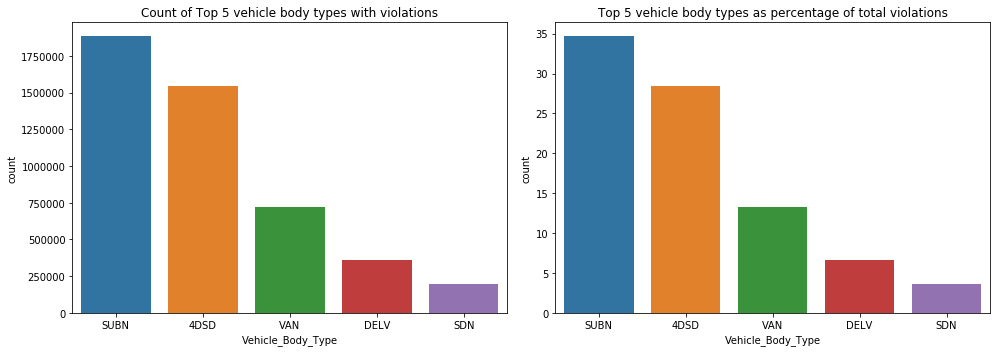

In [72]:
plt.figure(figsize = (14,5))
plt.subplot(1,2,1)
sns.barplot(x = 'Vehicle_Body_Type',y = 'count',data = df,order = code_order)
plt.gca().set_title('Count of Top 5 vehicle body types with violations')
plt.subplot(1,2,2)
sns.barplot(x = 'Vehicle_Body_Type',y = 'count',data = df1,order = code_order)
plt.gca().set_title('Top 5 vehicle body types as percentage of total violations')
plt.tight_layout()
plt.show()

In [73]:
# Sum of percentages
df1['count'].sum()

86.69

### Vehicle_Make

In [74]:
df = top5_vm.limit(5).toPandas()
df1 = df.copy()
df1['count'] = round(100*df1['count']/rows2,2)
code_order = df.sort_values('count',ascending = False).Vehicle_Make

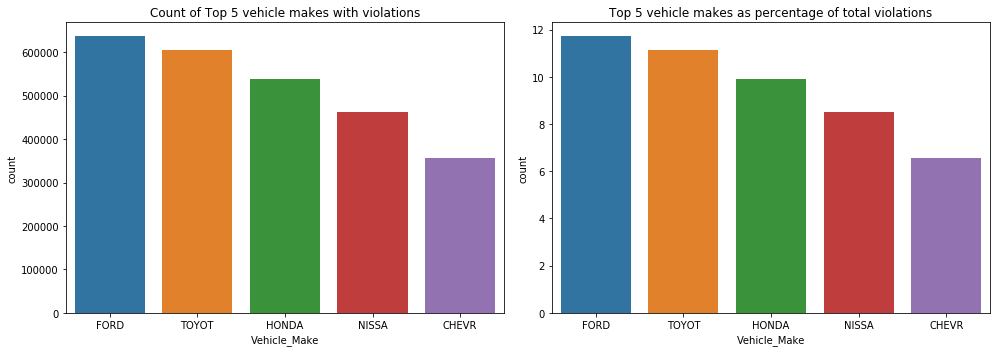

In [75]:
plt.figure(figsize = (14,5))
plt.subplot(1,2,1)
sns.barplot(x = 'Vehicle_Make',y = 'count',data = df,order = code_order)
plt.gca().set_title('Count of Top 5 vehicle makes with violations')
plt.subplot(1,2,2)
sns.barplot(x = 'Vehicle_Make',y = 'count',data = df1,order = code_order)
plt.gca().set_title('Top 5 vehicle makes as percentage of total violations')
plt.tight_layout()
plt.show()

In [76]:
# Sum of percentages
df1['count'].sum()

47.839999999999996

- The Top 5 Vehicle Body Types are `SUBN,4DSD,VAN,DELV,SDN` and all of them combined compraise a total of about 87% of violations
- The Top 5 Vehicle makes are `FORD,TOYOT,HONDA,NISSA,CHEVR` and all of them combined compraise a total of about 48% of violations

### Question 3

### Violation_Precinct

In [77]:
top5_vp = nyc_2017.groupby('Violation_Precinct').count().sort(col('count').desc())
top5_ip = nyc_2017.groupby('Issuer_Precinct').count().sort(col('count').desc())

In [78]:
top5_vp = top5_vp.filter(top5_vp.Violation_Precinct != 0)
top5_ip = top5_ip.filter(top5_ip.Issuer_Precinct != 0)

In [79]:
print_bold('Top 5 Precincts type with violations:')
top5_vp.show(5)
print_bold('Top 5 Precincts that issued violations:')
top5_ip.show(5)

Top 5 Precincts type with violations:
+------------------+------+
|Violation_Precinct| count|
+------------------+------+
|                19|274445|
|                14|203553|
|                 1|174702|
|                18|169131|
|               114|147444|
+------------------+------+
only showing top 5 rows

Top 5 Precincts that issued violations:
+---------------+------+
|Issuer_Precinct| count|
+---------------+------+
|             19|266961|
|             14|200495|
|              1|168740|
|             18|162994|
|            114|144054|
+---------------+------+
only showing top 5 rows



### Violation_Precinct

In [80]:
df = top5_vp.limit(5).toPandas()
df1 = df.copy()
df1['count'] = round(100*df1['count']/rows2,2)
code_order = df.sort_values('count',ascending = False).Violation_Precinct

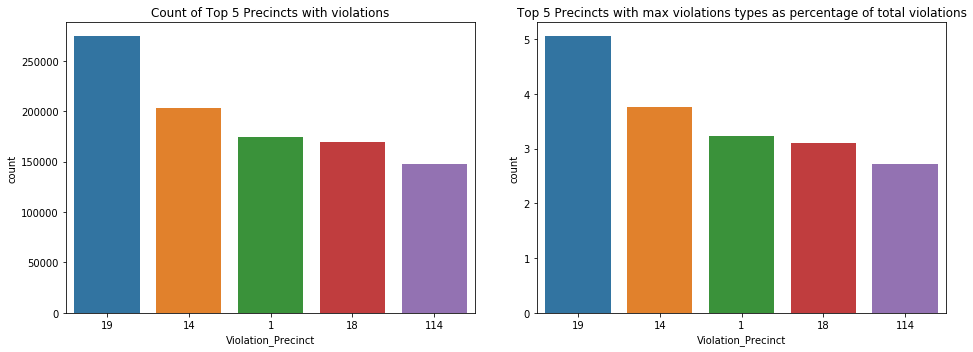

In [81]:
plt.figure(figsize = (14,5))
plt.subplot(1,2,1)
sns.barplot(x = 'Violation_Precinct',y = 'count',data = df,order = code_order)
plt.gca().set_title('Count of Top 5 Precincts with violations')
plt.subplot(1,2,2)
sns.barplot(x = 'Violation_Precinct',y = 'count',data = df1,order = code_order)
plt.gca().set_title('Top 5 Precincts with max violations types as percentage of total violations')
plt.tight_layout()
plt.show()

In [82]:
# Sum of percentages
df1['count'].sum()

17.84

### Issuer_Precinct

In [83]:
df = top5_ip.limit(5).toPandas()
df1 = df.copy()
df1['count'] = round(100*df1['count']/rows2,2)
code_order = df.sort_values('count',ascending = False).Issuer_Precinct

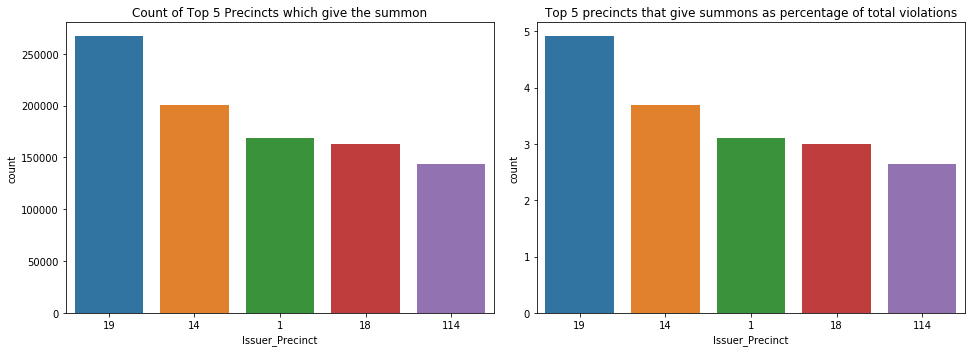

In [84]:
plt.figure(figsize = (14,5))
plt.subplot(1,2,1)
sns.barplot(x = 'Issuer_Precinct',y = 'count',data = df,order = code_order)
plt.gca().set_title('Count of Top 5 Precincts which give the summon')
plt.subplot(1,2,2)
sns.barplot(x = 'Issuer_Precinct',y = 'count',data = df1,order = code_order)
plt.gca().set_title('Top 5 precincts that give summons as percentage of total violations')
plt.tight_layout()
plt.show()

In [85]:
# Sum of percentages
df1['count'].sum()

17.36

- The Top 5 Violation_Precincts are `19,14,1,18,114` and all of them combined compraise a total of about 17.84% of violations
- The Top 5 Issuer_Precincts are `19,14,1,18,114` and all of them combined compraise a total of about 17.36% of violations

### Question 4 : Violation codes in top 3 Issuer_Precincts

`19,14,1` are the precincts that issued the maximum number of tickets

### Precinct 19

In [86]:
rows3 = nyc_2017.filter((nyc_2017['Issuer_Precinct'] ==19)).count()
top3_violation = nyc_2017.filter((nyc_2017['Issuer_Precinct'] ==19)).groupby('Violation_Code').count().sort(col('count').desc())

In [87]:
print_bold('Top 5 violation codes:')
top3_violation.show(5)

Top 5 violation codes:
+--------------+-----+
|Violation_Code|count|
+--------------+-----+
|            46|48445|
|            38|36386|
|            37|36056|
|            14|29797|
|            21|28415|
+--------------+-----+
only showing top 5 rows



In [88]:
df1 = top3_violation.limit(10).toPandas()
df11 = df1.copy()
df11['count'] = round(100*df11['count']/rows3,2)
code_order1 = df1.sort_values('count',ascending = False).Violation_Code

In [89]:
# Sum of percentages
df11['count'].sum()

85.95

### Precinct 14

In [90]:
rows3 = nyc_2017.filter((nyc_2017['Issuer_Precinct'] ==14)).count()
top3_violation = nyc_2017.filter((nyc_2017['Issuer_Precinct'] ==14)).groupby('Violation_Code').count().sort(col('count').desc())

In [91]:
print_bold('Top 5 violation codes:')
top3_violation.show(5)

Top 5 violation codes:
+--------------+-----+
|Violation_Code|count|
+--------------+-----+
|            14|45036|
|            69|30464|
|            31|22555|
|            47|18364|
|            42|10027|
+--------------+-----+
only showing top 5 rows



In [92]:
df2 = top3_violation.limit(10).toPandas()
df21 = df2.copy()
df21['count'] = round(100*df21['count']/rows3,2)
code_order2 = df2.sort_values('count',ascending = False).Violation_Code

In [93]:
# Sum of percentages
df21['count'].sum()

78.07000000000001

### Precinct 1

In [94]:
rows3 = nyc_2017.filter((nyc_2017['Issuer_Precinct'] ==1)).count()
top3_violation = nyc_2017.filter((nyc_2017['Issuer_Precinct'] ==1)).groupby('Violation_Code').count().sort(col('count').desc())

In [95]:
print_bold('Top 5 violation codes:')
top3_violation.show(5)

Top 5 violation codes:
+--------------+-----+
|Violation_Code|count|
+--------------+-----+
|            14|38354|
|            16|19081|
|            20|15408|
|            46|12745|
|            38| 8535|
+--------------+-----+
only showing top 5 rows



In [96]:
df3 = top3_violation.limit(10).toPandas()
df31 = df3.copy()
df31['count'] = round(100*df31['count']/rows3,2)
code_order3 = df3.sort_values('count',ascending = False).Violation_Code

In [97]:
# Sum of percentages
df31['count'].sum()

74.08999999999999

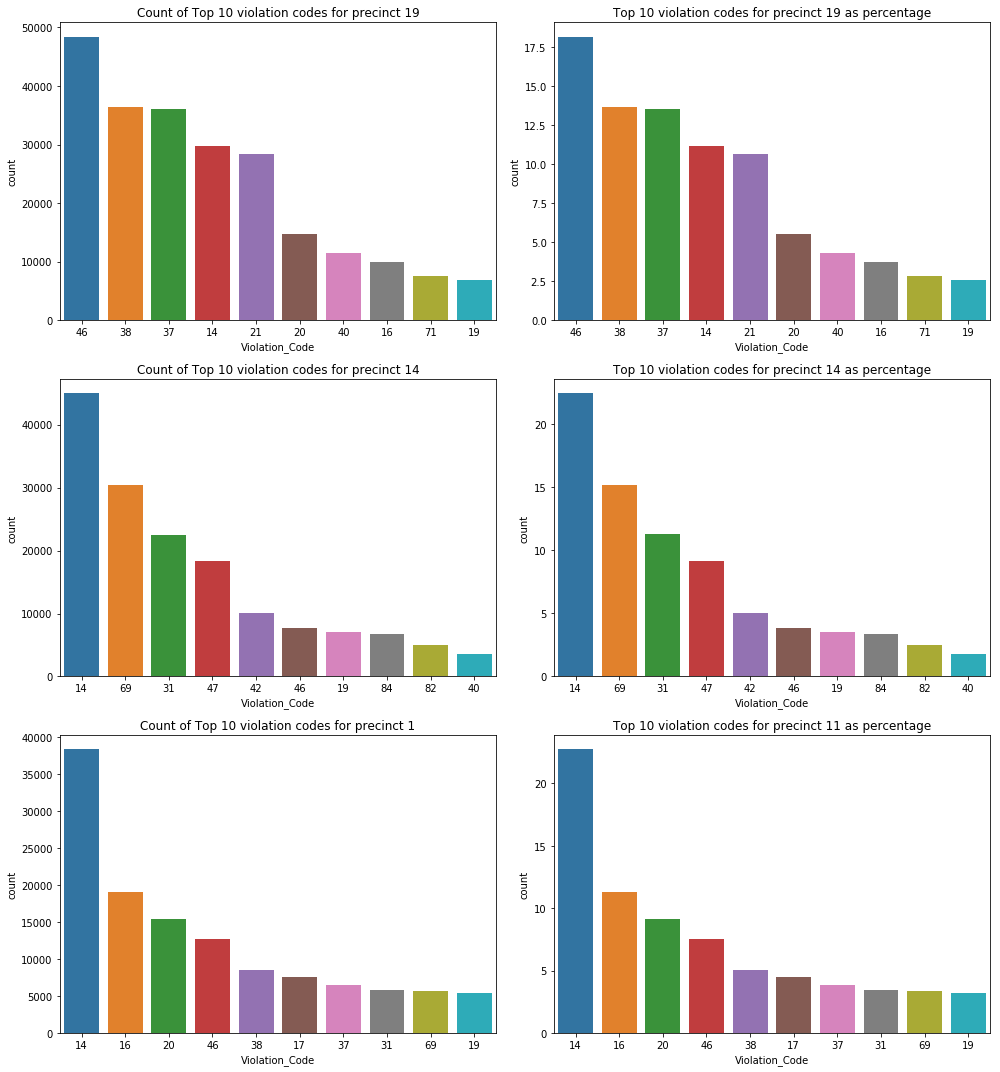

In [98]:
plt.figure(figsize = (14,15))
plt.subplot(3,2,1)
sns.barplot(x = 'Violation_Code',y = 'count',data = df1,order = code_order1)
plt.gca().set_title('Count of Top 10 violation codes for precinct 19')
plt.subplot(3,2,2)
sns.barplot(x = 'Violation_Code',y = 'count',data = df11,order = code_order1)
plt.gca().set_title('Top 10 violation codes for precinct 19 as percentage')
plt.subplot(3,2,3)
sns.barplot(x = 'Violation_Code',y = 'count',data = df2,order = code_order2)
plt.gca().set_title('Count of Top 10 violation codes for precinct 14')
plt.subplot(3,2,4)
sns.barplot(x = 'Violation_Code',y = 'count',data = df21,order = code_order2)
plt.gca().set_title('Top 10 violation codes for precinct 14 as percentage')
plt.subplot(3,2,5)
sns.barplot(x = 'Violation_Code',y = 'count',data = df3,order = code_order3)
plt.gca().set_title('Count of Top 10 violation codes for precinct 1')
plt.subplot(3,2,6)
sns.barplot(x = 'Violation_Code',y = 'count',data = df31,order = code_order3)
plt.gca().set_title('Top 10 violation codes for precinct 11 as percentage')
plt.tight_layout()
plt.show()

In [99]:
set(code_order1)&set(code_order2)&set(code_order3)

{14, 19, 46}

- The figure above shows the top violation codes for the top 3 precincts with violations.
- The top 10 violations in respective precincts have almost 75% of violations in the precincts, 86% for precinct 19, 74% for precinct 14 and 78% for precinct 1
- 14,46 and 19 are the 4 violations that are common in 3 precincts and 14 and 46 seems to have a large portion of violations in all the 3 precincts

### Question 5

### (a) : Handling Null values

We have already seen in the data cleaning step that certain columns have `nan` values, but these are not found using any inbult nan method. The reason might be is these `nan` values are stored as string and not as a null value and hence these are found only by using filter method

In [100]:
nyc_2017_1 = nyc_2017.filter(nyc_2017.Violation_Time != 'nan')

In [101]:
print_bold('No of rows in Initial dataframe:')
print(nyc_2017.count())
print_bold('No of null values in Violation_Time:')
print(nyc_2017.filter(nyc_2017['Violation_Time'] == 'nan').count())
print_bold('No of rows in cleaned dataframe:')
print(nyc_2017_1.count())

No of rows in Initial dataframe:
5431918
No of null values in Violation_Time:
16
No of rows in cleaned dataframe:
5431902


### (b) : Extracting time from ViolationTime

In [102]:
nyc_2017_1 = nyc_2017_1.withColumn('hour',when(substring(col('Violation_Time'),-1,1) == 'P',12+(substring(col('Violation_Time'),1,2).cast('Int'))).otherwise((substring(col('Violation_Time'),1,2).cast('Int'))))
nyc_2017_1 = nyc_2017_1.withColumn('minutes',substring(col('Violation_Time'),3,2))

In [103]:
nyc_2017_1.limit(5).toPandas()

,Summons_Number,Plate_ID,Registration_State,Issue_Date,Violation_Code,Vehicle_Body_Type,Vehicle_Make,Violation_Precinct,Issuer_Precinct,Violation_Time,hour,minutes
0,8478629828,66623ME,NY,2017-06-14,47,REFG,MITSU,14,14,1120A,11,20
1,5096917368,FZD8593,NY,2017-06-13,7,SUBN,ME/BE,0,0,0852P,20,52
2,1407740258,2513JMG,NY,2017-01-11,78,DELV,FRUEH,106,106,0015A,0,15
3,1413656420,T672371C,NY,2017-02-04,40,TAXI,TOYOT,73,73,0525A,5,25
4,8480309064,51771JW,NY,2017-01-26,64,VAN,INTER,17,17,0256P,14,56


### (c) : Dividing into bins and top violations in each bin

In [104]:
nyc_2017_1 = nyc_2017_1.withColumn('day_bin',when(col('hour') < 4,1).when(((col('hour') >=4)&(col('hour') <8)),2) \
                      .when(((col('hour') >=8)&(col('hour') <12)),3).when(((col('hour') >=12)&(col('hour') <16)),4) \
                      .when(((col('hour') >=16)&(col('hour') <20)),5).when(col('hour') >=20,6))

In [105]:
nyc_2017_1.limit(5).toPandas()

,Summons_Number,Plate_ID,Registration_State,Issue_Date,Violation_Code,Vehicle_Body_Type,Vehicle_Make,Violation_Precinct,Issuer_Precinct,Violation_Time,hour,minutes,day_bin
0,8478629828,66623ME,NY,2017-06-14,47,REFG,MITSU,14,14,1120A,11,20,3
1,5096917368,FZD8593,NY,2017-06-13,7,SUBN,ME/BE,0,0,0852P,20,52,6
2,1407740258,2513JMG,NY,2017-01-11,78,DELV,FRUEH,106,106,0015A,0,15,1
3,1413656420,T672371C,NY,2017-02-04,40,TAXI,TOYOT,73,73,0525A,5,25,2
4,8480309064,51771JW,NY,2017-01-26,64,VAN,INTER,17,17,0256P,14,56,4


### Bin 1: 12 - 4 AM

In [106]:
rows3 = nyc_2017_1.filter((nyc_2017_1['day_bin'] ==1)).count()
top3_violation =  nyc_2017_1.filter((nyc_2017_1['day_bin'] ==1)).groupby('Violation_Code').count().sort(col('count').desc())

In [107]:
print_bold('Top 3 violation codes:')
top3_violation.show(3)

Top 3 violation codes:
+--------------+-----+
|Violation_Code|count|
+--------------+-----+
|            21|34704|
|            40|23629|
|            14|14168|
+--------------+-----+
only showing top 3 rows



In [108]:
df1 = top3_violation.limit(3).toPandas()
df11 = df1.copy()
df11['count'] = round(100*df11['count']/rows3,2)
code_order1 = df1.sort_values('count',ascending = False).Violation_Code

In [109]:
# Sum of percentages
df11['count'].sum()

49.21999999999999

### bin 2: 4AM-8AM

In [110]:
rows3 = nyc_2017_1.filter((nyc_2017_1['day_bin'] ==2)).count()
top3_violation =  nyc_2017_1.filter((nyc_2017_1['day_bin'] ==2)).groupby('Violation_Code').count().sort(col('count').desc())

In [111]:
print_bold('Top 3 violation codes:')
top3_violation.show(3)

Top 3 violation codes:
+--------------+-----+
|Violation_Code|count|
+--------------+-----+
|            14|74114|
|            40|60652|
|            21|57897|
+--------------+-----+
only showing top 3 rows



In [112]:
df2 = top3_violation.limit(3).toPandas()
df21 = df2.copy()
df21['count'] = round(100*df21['count']/rows3,2)
code_order2 = df2.sort_values('count',ascending = False).Violation_Code

In [113]:
# Sum of percentages
df21['count'].sum()

42.82

### bin 3: 8AM-12PM

In [114]:
rows3 = nyc_2017_1.filter((nyc_2017_1['day_bin'] ==3)).count()
top3_violation =  nyc_2017_1.filter((nyc_2017_1['day_bin'] ==3)).groupby('Violation_Code').count().sort(col('count').desc())

In [115]:
print_bold('Top 3 violation codes:')
top3_violation.show(3)

Top 3 violation codes:
+--------------+------+
|Violation_Code| count|
+--------------+------+
|            21|598070|
|            36|348165|
|            38|176570|
+--------------+------+
only showing top 3 rows



In [116]:
df3 = top3_violation.limit(3).toPandas()
df31 = df3.copy()
df31['count'] = round(100*df31['count']/rows3,2)
code_order3 = df3.sort_values('count',ascending = False).Violation_Code

In [117]:
# Sum of percentages
df31['count'].sum()

51.89

### Bin 4: 12PM - 4PM

In [118]:
rows3 = nyc_2017_1.filter((nyc_2017_1['day_bin'] ==4)).count()
top3_violation =  nyc_2017_1.filter((nyc_2017_1['day_bin'] ==4)).groupby('Violation_Code').count().sort(col('count').desc())

In [119]:
print_bold('Top 3 violation codes:')
top3_violation.show(3)

Top 3 violation codes:
+--------------+------+
|Violation_Code| count|
+--------------+------+
|            38|184829|
|            36|184293|
|            37|130692|
+--------------+------+
only showing top 3 rows



In [120]:
df4 = top3_violation.limit(3).toPandas()
df41 = df4.copy()
df41['count'] = round(100*df41['count']/rows3,2)
code_order4 = df4.sort_values('count',ascending = False).Violation_Code

In [121]:
# Sum of percentages
df41['count'].sum()

37.099999999999994

### Bin 5: 4PM - 8PM

In [122]:
rows3 = nyc_2017_1.filter((nyc_2017_1['day_bin'] ==5)).count()
top3_violation =  nyc_2017_1.filter((nyc_2017_1['day_bin'] ==5)).groupby('Violation_Code').count().sort(col('count').desc())

In [123]:
print_bold('Top 3 violation codes:')
top3_violation.show(3)

Top 3 violation codes:
+--------------+------+
|Violation_Code| count|
+--------------+------+
|            38|102855|
|            14| 75902|
|            37| 70345|
+--------------+------+
only showing top 3 rows



In [124]:
df5 = top3_violation.limit(3).toPandas()
df51 = df5.copy()
df51['count'] = round(100*df51['count']/rows3,2)
code_order5 = df5.sort_values('count',ascending = False).Violation_Code

In [125]:
# Sum of percentages
df51['count'].sum()

39.07

### Bin 6 : 8PM - 12AM

In [126]:
rows3 = nyc_2017_1.filter((nyc_2017_1['day_bin'] ==6)).count()
top3_violation =  nyc_2017_1.filter((nyc_2017_1['day_bin'] ==6)).groupby('Violation_Code').count().sort(col('count').desc())

In [127]:
print_bold('Top 3 violation codes:')
top3_violation.show(3)

Top 3 violation codes:
+--------------+------+
|Violation_Code| count|
+--------------+------+
|            36|101991|
|            38| 76314|
|            21| 72568|
+--------------+------+
only showing top 3 rows



In [128]:
df6 = top3_violation.limit(3).toPandas()
df61 = df6.copy()
df61['count'] = round(100*df61['count']/rows3,2)
code_order6 = df6.sort_values('count',ascending = False).Violation_Code

In [129]:
df61

,Violation_Code,count
0,36,14.86
1,38,11.12
2,21,10.57


In [130]:
# Sum of percentages
df61['count'].sum()

36.55

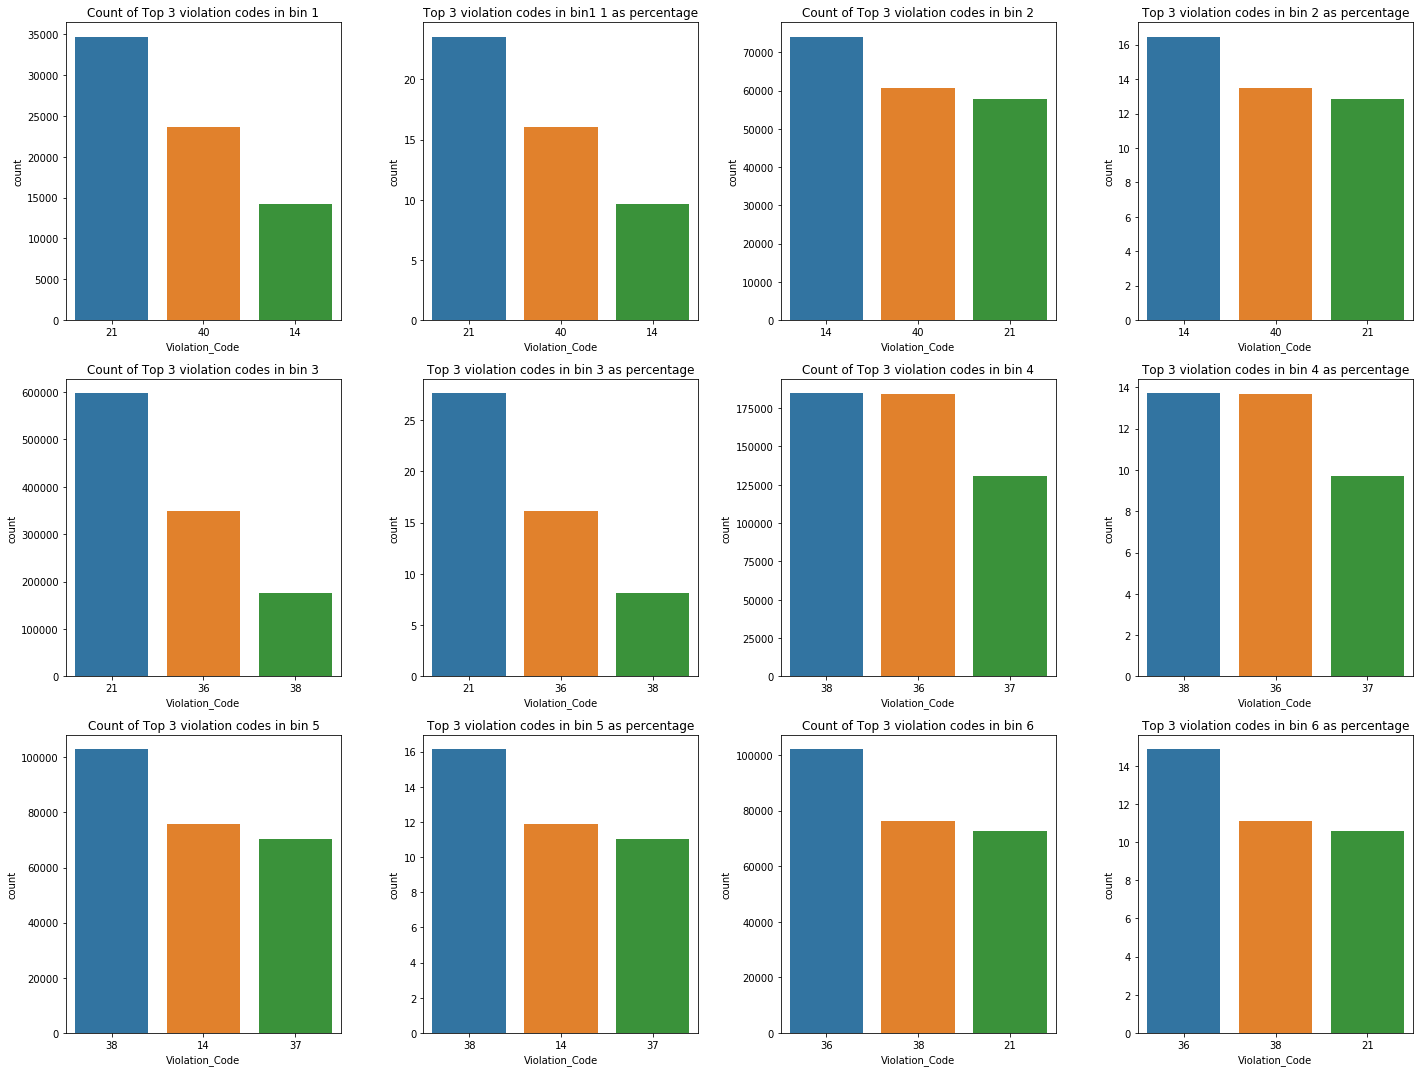

In [131]:
plt.figure(figsize = (20,15))
plt.subplot(3,4,1)
sns.barplot(x = 'Violation_Code',y = 'count',data = df1,order = code_order1)
plt.gca().set_title('Count of Top 3 violation codes in bin 1')
plt.subplot(3,4,2)
sns.barplot(x = 'Violation_Code',y = 'count',data = df11,order = code_order1)
plt.gca().set_title('Top 3 violation codes in bin1 1 as percentage')
plt.subplot(3,4,3)
sns.barplot(x = 'Violation_Code',y = 'count',data = df2,order = code_order2)
plt.gca().set_title('Count of Top 3 violation codes in bin 2')
plt.subplot(3,4,4)
sns.barplot(x = 'Violation_Code',y = 'count',data = df21,order = code_order2)
plt.gca().set_title('Top 3 violation codes in bin 2 as percentage')
plt.subplot(3,4,5)
sns.barplot(x = 'Violation_Code',y = 'count',data = df3,order = code_order3)
plt.gca().set_title('Count of Top 3 violation codes in bin 3')
plt.subplot(3,4,6)
sns.barplot(x = 'Violation_Code',y = 'count',data = df31,order = code_order3)
plt.gca().set_title('Top 3 violation codes in bin 3 as percentage')
plt.subplot(3,4,7)
sns.barplot(x = 'Violation_Code',y = 'count',data = df4,order = code_order4)
plt.gca().set_title('Count of Top 3 violation codes in bin 4')
plt.subplot(3,4,8)
sns.barplot(x = 'Violation_Code',y = 'count',data = df41,order = code_order4)
plt.gca().set_title('Top 3 violation codes in bin 4 as percentage')
plt.subplot(3,4,9)
sns.barplot(x = 'Violation_Code',y = 'count',data = df5,order = code_order5)
plt.gca().set_title('Count of Top 3 violation codes in bin 5')
plt.subplot(3,4,10)
sns.barplot(x = 'Violation_Code',y = 'count',data = df51,order = code_order5)
plt.gca().set_title('Top 3 violation codes in bin 5 as percentage')
plt.subplot(3,4,11)
sns.barplot(x = 'Violation_Code',y = 'count',data = df6,order = code_order6)
plt.gca().set_title('Count of Top 3 violation codes in bin 6')
plt.subplot(3,4,12)
sns.barplot(x = 'Violation_Code',y = 'count',data = df61,order = code_order6)
plt.gca().set_title('Top 3 violation codes in bin 6 as percentage')


plt.tight_layout()
plt.show()

- In the early morning and late nights 21 seems to be the violation code that is dominating
- In the normal day hours, 36 and 38 violations codes seems to be lot higher

### (d) : bin-wise analysis for top 3 violation codes

In [132]:
nyc_2017_1.groupby('day_bin').count().sort(col('count').desc()).show()

+-------+-------+
|day_bin|  count|
+-------+-------+
|      3|2163568|
|      4|1347178|
|      6| 686431|
|      5| 637540|
|      2| 449885|
|      1| 147300|
+-------+-------+



The most parking tickets were given in the 3 and 4 bins which are between 8 AM and 4 PM.

In [133]:
nyc_2017_1.groupby('Violation_Code').count().sort(col('count').desc()).show(3)

+--------------+------+
|Violation_Code| count|
+--------------+------+
|            21|768087|
|            36|662765|
|            38|542079|
+--------------+------+
only showing top 3 rows



The 3 most common violations are 21,36 and 38.

### Violation code 21

In [134]:
rows3 = nyc_2017_1.filter((nyc_2017_1['Violation_Code'] ==21)).count()
top3_violation =  nyc_2017_1.filter((nyc_2017_1['Violation_Code'] ==21)).groupby('day_bin').count().sort(col('count').desc())

In [135]:
print_bold('Violations bin wise:')
top3_violation.show(5)

Violations bin wise:
+-------+------+
|day_bin| count|
+-------+------+
|      3|598070|
|      6| 72568|
|      2| 57897|
|      1| 34704|
|      4|  4589|
+-------+------+
only showing top 5 rows



In [136]:
df1 = top3_violation.limit(5).toPandas()
df11 = df1.copy()
df11['count'] = round(100*df11['count']/rows3,2)
code_order1 = df1.sort_values('count',ascending = False).day_bin

In [137]:
# Sum of percentages
df11['count'].sum()

99.97

### Violation code 36

In [138]:
rows3 = nyc_2017_1.filter((nyc_2017_1['Violation_Code'] ==36)).count()
top3_violation =  nyc_2017_1.filter((nyc_2017_1['Violation_Code'] ==36)).groupby('day_bin').count().sort(col('count').desc())

In [139]:
print_bold('Violations bin wise:')
top3_violation.show(5)

Violations bin wise:
+-------+------+
|day_bin| count|
+-------+------+
|      3|348165|
|      4|184293|
|      6|101991|
|      2| 14782|
|      5| 13534|
+-------+------+



In [140]:
df2 = top3_violation.limit(5).toPandas()
df21 = df2.copy()
df21['count'] = round(100*df21['count']/rows3,2)
code_order2 = df2.sort_values('count',ascending = False).day_bin

In [141]:
# Sum of percentages
df21['count'].sum()

100.00000000000001

### Violation Code 38

In [142]:
rows3 = nyc_2017_1.filter((nyc_2017_1['Violation_Code'] ==38)).count()
top3_violation =  nyc_2017_1.filter((nyc_2017_1['Violation_Code'] ==38)).groupby('day_bin').count().sort(col('count').desc())

In [143]:
print_bold('Violations bin wise:')
top3_violation.show(5)

Violations bin wise:
+-------+------+
|day_bin| count|
+-------+------+
|      4|184829|
|      3|176570|
|      5|102855|
|      6| 76314|
|      2|  1273|
+-------+------+
only showing top 5 rows



In [144]:
df3 = top3_violation.limit(5).toPandas()
df31 = df3.copy()
df31['count'] = round(100*df31['count']/rows3,2)
code_order3 = df3.sort_values('count',ascending = False).day_bin

In [145]:
# Sum of percentages
df31['count'].sum()

99.95

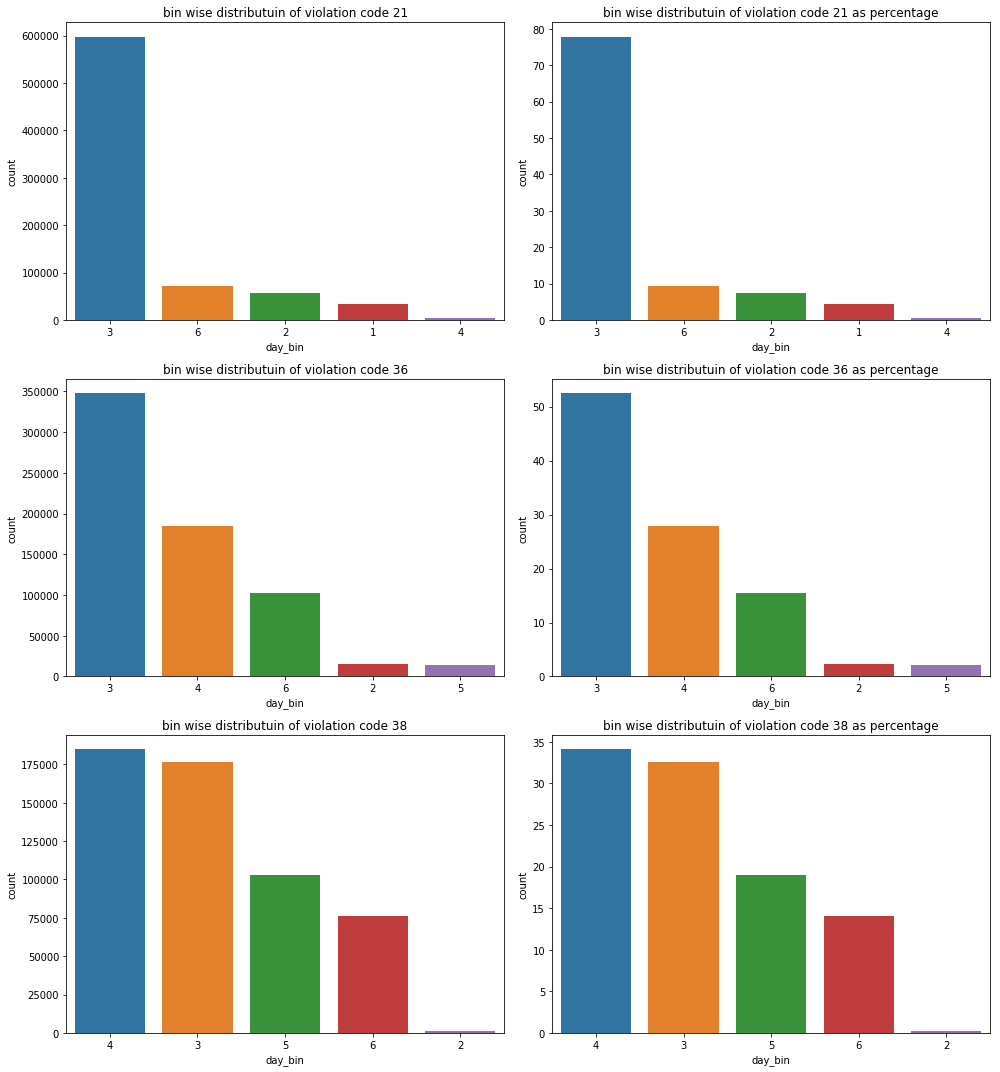

In [146]:
plt.figure(figsize = (14,15))
plt.subplot(3,2,1)
sns.barplot(x = 'day_bin',y = 'count',data = df1,order = code_order1)
plt.gca().set_title('bin wise distributuin of violation code 21')
plt.subplot(3,2,2)
sns.barplot(x = 'day_bin',y = 'count',data = df11,order = code_order1)
plt.gca().set_title('bin wise distributuin of violation code 21 as percentage')
plt.subplot(3,2,3)
sns.barplot(x = 'day_bin',y = 'count',data = df2,order = code_order2)
plt.gca().set_title('bin wise distributuin of violation code 36')
plt.subplot(3,2,4)
sns.barplot(x = 'day_bin',y = 'count',data = df21,order = code_order2)
plt.gca().set_title('bin wise distributuin of violation code 36 as percentage')
plt.subplot(3,2,5)
sns.barplot(x = 'day_bin',y = 'count',data = df3,order = code_order3)
plt.gca().set_title('bin wise distributuin of violation code 38')
plt.subplot(3,2,6)
sns.barplot(x = 'day_bin',y = 'count',data = df31,order = code_order3)
plt.gca().set_title('bin wise distributuin of violation code 38 as percentage')
plt.tight_layout()
plt.show()

3 seems to be the that has the most number of violations in 2 out 3 validation codes and even in the case where 3 was not the bin with maximum violations it seems to be really close to the top slot. Hence 3 seems to slot where maximum tickets were issued, which is 8 AM to 12 PM.

### Question 6: Season wise analysis

In [147]:
nyc_2017_1 = nyc_2017_1.withColumn('Month',month(col('Issue_Date')))

In [148]:
nyc_2017_1 = nyc_2017_1.withColumn('season',when(col('Month') < 4,1).when(((col('Month') >=4)&(col('Month') <7)),2) \
                      .when(((col('Month') >=7)&(col('Month') <10)),3).when(((col('Month') >=10)&(col('Month') <=12)),4))

In [149]:
nyc_2017_1.limit(5).toPandas()

,Summons_Number,Plate_ID,Registration_State,Issue_Date,Violation_Code,Vehicle_Body_Type,Vehicle_Make,Violation_Precinct,Issuer_Precinct,Violation_Time,hour,minutes,day_bin,Month,season
0,8478629828,66623ME,NY,2017-06-14,47,REFG,MITSU,14,14,1120A,11,20,3,6,2
1,5096917368,FZD8593,NY,2017-06-13,7,SUBN,ME/BE,0,0,0852P,20,52,6,6,2
2,1407740258,2513JMG,NY,2017-01-11,78,DELV,FRUEH,106,106,0015A,0,15,1,1,1
3,1413656420,T672371C,NY,2017-02-04,40,TAXI,TOYOT,73,73,0525A,5,25,2,2,1
4,8480309064,51771JW,NY,2017-01-26,64,VAN,INTER,17,17,0256P,14,56,4,1,1


In [150]:
nyc_2017_1.groupby('season').count().sort(col('count').desc()).show()

+------+-------+
|season|  count|
+------+-------+
|     2|2760823|
|     1|2669063|
|     3|   1046|
|     4|    970|
+------+-------+



1 and 2 seasons gave almost 100% of the tickets, which are Jan-March and April-June

### Season 1

In [151]:
rows3 = nyc_2017_1.filter((nyc_2017_1['season'] ==1)).count()
top3_violation =  nyc_2017_1.filter((nyc_2017_1['season'] ==1)).groupby('Violation_Code').count().sort(col('count').desc())

In [152]:
print_bold('Top 3 violation codes:')
top3_violation.show(3)

Top 3 violation codes:
+--------------+------+
|Violation_Code| count|
+--------------+------+
|            21|373874|
|            36|348240|
|            38|287000|
+--------------+------+
only showing top 3 rows



In [153]:
df1 = top3_violation.limit(3).toPandas()
df11 = df1.copy()
df11['count'] = round(100*df11['count']/rows3,2)
code_order1 = df1.sort_values('count',ascending = False).Violation_Code

In [154]:
# Sum of percentages
df11['count'].sum()

37.81

### Season 2

In [155]:
rows3 = nyc_2017_1.filter((nyc_2017_1['season'] ==2)).count()
top3_violation =  nyc_2017_1.filter((nyc_2017_1['season'] ==2)).groupby('Violation_Code').count().sort(col('count').desc())

In [156]:
print_bold('Top 3 violation codes:')
top3_violation.show(3)

Top 3 violation codes:
+--------------+------+
|Violation_Code| count|
+--------------+------+
|            21|393885|
|            36|314525|
|            38|255064|
+--------------+------+
only showing top 3 rows



In [157]:
df2 = top3_violation.limit(3).toPandas()
df21 = df2.copy()
df21['count'] = round(100*df21['count']/rows3,2)
code_order2 = df2.sort_values('count',ascending = False).Violation_Code

In [158]:
# Sum of percentages
df21['count'].sum()

34.9

### Season 3

In [159]:
rows3 = nyc_2017_1.filter((nyc_2017_1['season'] ==3)).count()
top3_violation =  nyc_2017_1.filter((nyc_2017_1['season'] ==3)).groupby('Violation_Code').count().sort(col('count').desc())

In [160]:
print_bold('Top 3 violation codes:')
top3_violation.show(3)

Top 3 violation codes:
+--------------+-----+
|Violation_Code|count|
+--------------+-----+
|            21|  228|
|            46|  219|
|            40|  109|
+--------------+-----+
only showing top 3 rows



In [161]:
df3 = top3_violation.limit(3).toPandas()
df31 = df3.copy()
df31['count'] = round(100*df31['count']/rows3,2)
code_order3 = df3.sort_values('count',ascending = False).Violation_Code

In [162]:
# Sum of percentages
df31['count'].sum()

53.160000000000004

### Season 4

In [163]:
rows3 = nyc_2017_1.filter((nyc_2017_1['season'] ==4)).count()
top3_violation =  nyc_2017_1.filter((nyc_2017_1['season'] ==4)).groupby('Violation_Code').count().sort(col('count').desc())

In [164]:
print_bold('Top 3 violation codes:')
top3_violation.show(3)

Top 3 violation codes:
+--------------+-----+
|Violation_Code|count|
+--------------+-----+
|            46|  219|
|            40|  121|
|            21|  100|
+--------------+-----+
only showing top 3 rows



In [165]:
df4 = top3_violation.limit(3).toPandas()
df41 = df4.copy()
df41['count'] = round(100*df41['count']/rows3,2)
code_order4 = df4.sort_values('count',ascending = False).Violation_Code

In [166]:
# Sum of percentages
df41['count'].sum()

45.36

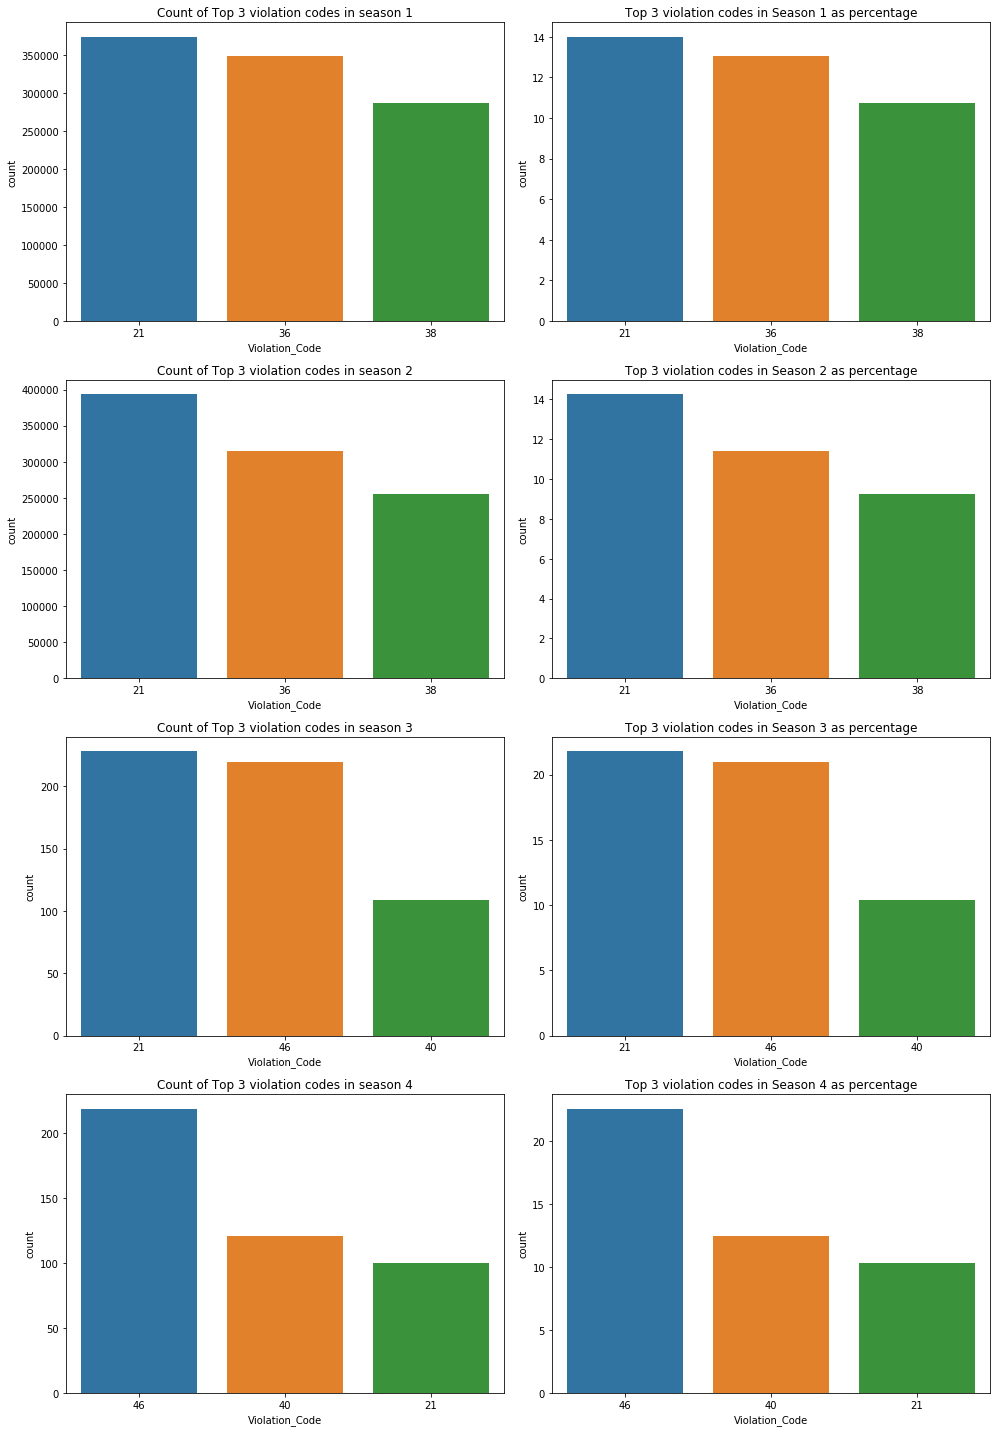

In [167]:
plt.figure(figsize = (14,20))
plt.subplot(4,2,1)
sns.barplot(x = 'Violation_Code',y = 'count',data = df1,order = code_order1)
plt.gca().set_title('Count of Top 3 violation codes in season 1')
plt.subplot(4,2,2)
sns.barplot(x = 'Violation_Code',y = 'count',data = df11,order = code_order1)
plt.gca().set_title('Top 3 violation codes in Season 1 as percentage')
plt.subplot(4,2,3)
sns.barplot(x = 'Violation_Code',y = 'count',data = df2,order = code_order2)
plt.gca().set_title('Count of Top 3 violation codes in season 2')
plt.subplot(4,2,4)
sns.barplot(x = 'Violation_Code',y = 'count',data = df21,order = code_order2)
plt.gca().set_title('Top 3 violation codes in Season 2 as percentage')
plt.subplot(4,2,5)
sns.barplot(x = 'Violation_Code',y = 'count',data = df3,order = code_order3)
plt.gca().set_title('Count of Top 3 violation codes in season 3')
plt.subplot(4,2,6)
sns.barplot(x = 'Violation_Code',y = 'count',data = df31,order = code_order3)
plt.gca().set_title('Top 3 violation codes in Season 3 as percentage')
plt.subplot(4,2,7)
sns.barplot(x = 'Violation_Code',y = 'count',data = df4,order = code_order4)
plt.gca().set_title('Count of Top 3 violation codes in season 4')
plt.subplot(4,2,8)
sns.barplot(x = 'Violation_Code',y = 'count',data = df41,order = code_order4)
plt.gca().set_title('Top 3 violation codes in Season 4 as percentage')
plt.tight_layout()
plt.show()

- 21 seems to the most promiment violation code across most of the seasons
- 36,38 codes have large number of violation in season 1 and 2
- 46 and 40 replace 36 and 38 as larger violation codes in season 3 and season 4

### Question 7:

#### a. 3 most violation codes

In [168]:
count_3_vio = nyc_2017_1.groupby('Violation_Code').count().sort(col('count').desc()).limit(3)
count_3_vio.show()

+--------------+------+
|Violation_Code| count|
+--------------+------+
|            21|768087|
|            36|662765|
|            38|542079|
+--------------+------+



#### b. Then, visit the website:
http://www1.nyc.gov/site/finance/vehicles/services-violation-codes.page
It lists the fines associated with different violation codes. They’re divided into two categories: one for the highest-density locations in the city and the other for the rest of the city. For the sake of simplicity, take the average of the two.

In [169]:
avg_fine_21 = (65+45)/2
print('Average fine for violation_code 21 is:', avg_fine_21)

avg_fine_36 = (50+50)/2
print('Average fine for violation_code 36 is:', avg_fine_36)

avg_fine_38 = (65+35)/2
print('Average fine for violation_code 38 is:', avg_fine_38)

Average fine for violation_code 21 is: 55.0
Average fine for violation_code 36 is: 50.0
Average fine for violation_code 38 is: 50.0


In [170]:
count_3_vio = count_3_vio.withColumn('avg_fine',when(col('violation_code') == 21,avg_fine_21).when(col('violation_code') == 36,avg_fine_36) \
                       .when(col('violation_code') == 38,avg_fine_38))

In [171]:
count_3_vio.show()

+--------------+------+--------+
|Violation_Code| count|avg_fine|
+--------------+------+--------+
|            21|768087|    55.0|
|            36|662765|    50.0|
|            38|542079|    50.0|
+--------------+------+--------+



#### c. Fines collected for top 3 violations codes

In [172]:
count_3_vio = count_3_vio.withColumn('Fine_amount_collected',col('count')*col('avg_fine').cast('Decimal(10,0)'))

In [173]:
count_3_vio.show()

+--------------+------+--------+---------------------+
|Violation_Code| count|avg_fine|Fine_amount_collected|
+--------------+------+--------+---------------------+
|            21|768087|    55.0|             42244785|
|            36|662765|    50.0|             33138250|
|            38|542079|    50.0|             27103950|
+--------------+------+--------+---------------------+



In [174]:
print_bold('Total Collected Amount:')
count_3_vio.select(sum(col('Fine_amount_collected'))).show()

Total Collected Amount:
+--------------------------+
|sum(Fine_amount_collected)|
+--------------------------+
|                 102486985|
+--------------------------+



- code 21 has the highest amount collected with 42.2 million dollars
- The total collection for the top 3 codes is 102.4 million dollars

In [175]:
ss.stop()